# Clustering and Visualization of Publications

## Task Setting and Description

- **Objective:** Cluster publications based on abstracts to identify thematic groupings.
- **Tools:** Python, embedding models (e.g., bge-m3, OpenAI embeddings), clustering algorithms (e.g., K-Means), visualization libraries.

---
## Code Implementation

### 1. Install libraries and import data

Objective and Dataset Preparation
Objective:

Cluster publications based on abstracts to identify thematic groupings.
Data Loading and Preprocessing:

Loaded references_raw.json into references_df.
Dropped rows with missing abstracts to ensure accurate embedding generation.
Created publications_df with selected columns: date, title, doi, authors, journal, year, abstract, source_file.
Initialized an abstract_embedding column to store embeddings.

In [1]:
# Install necessary packages
!pip install pandas numpy matplotlib seaborn scikit-learn openai tqdm python-dotenv

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm
import openai
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

# Load the dataset
references_df = pd.read_json('/Users/max/Documents/Code/tsi-sota-ai/data/references_raw.json', orient='records', lines=True)

# Display the first few rows
references_df.head()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 13.3 MB/s eta 0:00:00 0:00:01


,date,title,doi,authors,journal,short_journal,volume,year,publisher,issue,page,abstract,source_file
0,2023-09-13,Transformative Procurement Trends: Integrating...,10.3390/logistics7030063,"[{'author_name': 'Areej Althabatah', 'author_s...",Logistics,Logistics,7.0,2023,MDPI AG,3.0,63,Background: the advent of Industry 4.0 (I4.0) ...,1.2.2.1 LR - The Specialist Shortage and its I...
1,2021-10-07,Exploring Progress with Supply Chain Risk Mana...,10.3390/logistics5040070,"[{'author_name': 'Remko van Hoek', 'author_slu...",Logistics,Logistics,5.0,2021,MDPI AG,4.0,70,Background: In response to calls for actionabl...,1.2.2.1 LR - The Specialist Shortage and its I...
2,2023-12-01,Exploring Applications and Practical Examples ...,10.3390/logistics7040091,"[{'author_name': 'João Reis', 'author_slug': '...",Logistics,Logistics,7.0,2023,MDPI AG,4.0,91,Background: Material Requirements Planning (MR...,1.2.2.1 LR - The Specialist Shortage and its I...
3,2021-09-27,Sustainable Innovations in the Food Industry t...,10.3390/logistics5040066,"[{'author_name': 'Saurabh Sharma', 'author_slu...",Logistics,Logistics,5.0,2021,MDPI AG,4.0,66,The agri-food sector is an endless source of e...,1.2.2.1 LR - The Specialist Shortage and its I...
4,2021-04-01,Artificial Intelligence (AI): Multidisciplinar...,10.1016/j.ijinfomgt.2019.08.002,"[{'author_name': 'Yogesh K. Dwivedi', 'author_...",International Journal of Information Management,International Journal of Information Management,57.0,2021,Elsevier BV,NaN,101994,"As far back as the industrial revolution, sign...",1.2.2.1 LR - The Specialist Shortage and its I...


In [2]:
import time 

# Check if 'abstract' column exists in the DataFrame
print("Columns in references_df:", references_df.columns.tolist())

# Drop rows with missing abstracts
references_df = references_df.dropna(subset=['abstract']).reset_index(drop=True)

# Display the number of publications after dropping missing abstracts
print(f"Number of publications after dropping missing abstracts: {len(references_df)}")

Columns in references_df: ['date', 'title', 'doi', 'authors', 'journal', 'short_journal', 'volume', 'year', 'publisher', 'issue', 'page', 'abstract', 'source_file']
Number of publications after dropping missing abstracts: 587


We will create a new dataframe to store embeddings in it

In [3]:
# Create a new DataFrame with selected columns
# Columns: date, title, doi, authors, journal, year, abstract, source_file
selected_columns = ['date', 'title', 'doi', 'authors', 'journal', 'year', 'abstract', 'source_file']
publications_df = references_df[selected_columns].copy()

# Initialize the 'abstract_embedding' column with None
publications_df['abstract_embedding'] = None

# Display the first few rows of the new DataFrame
publications_df.head()

,date,title,doi,authors,journal,year,abstract,source_file,abstract_embedding
0,2023-09-13,Transformative Procurement Trends: Integrating...,10.3390/logistics7030063,"[{'author_name': 'Areej Althabatah', 'author_s...",Logistics,2023,Background: the advent of Industry 4.0 (I4.0) ...,1.2.2.1 LR - The Specialist Shortage and its I...,None
1,2021-10-07,Exploring Progress with Supply Chain Risk Mana...,10.3390/logistics5040070,"[{'author_name': 'Remko van Hoek', 'author_slu...",Logistics,2021,Background: In response to calls for actionabl...,1.2.2.1 LR - The Specialist Shortage and its I...,None
2,2023-12-01,Exploring Applications and Practical Examples ...,10.3390/logistics7040091,"[{'author_name': 'João Reis', 'author_slug': '...",Logistics,2023,Background: Material Requirements Planning (MR...,1.2.2.1 LR - The Specialist Shortage and its I...,None
3,2021-09-27,Sustainable Innovations in the Food Industry t...,10.3390/logistics5040066,"[{'author_name': 'Saurabh Sharma', 'author_slu...",Logistics,2021,The agri-food sector is an endless source of e...,1.2.2.1 LR - The Specialist Shortage and its I...,None
4,2021-04-01,Artificial Intelligence (AI): Multidisciplinar...,10.1016/j.ijinfomgt.2019.08.002,"[{'author_name': 'Yogesh K. Dwivedi', 'author_...",International Journal of Information Management,2021,"As far back as the industrial revolution, sign...",1.2.2.1 LR - The Specialist Shortage and its I...,None


### 2. Generate embeddings

Embedding Model Used:

Utilized the OpenAI embedding model text-embedding-3-small to generate embeddings for abstracts.
Process:

Defined a function get_embedding(text, model) to fetch embeddings using OpenAI's API.
Iterated over each abstract, fetching embeddings with a 0.1-second delay between requests to respect API rate limits.
Stored embeddings in the abstract_embedding column and saved them as a NumPy array for future use.
Considerations:

Handled exceptions to manage potential API errors.
Saved the enriched DataFrame to publications_with_embeddings.json for persistence.

In [10]:
from openai import OpenAI
import time
from tqdm import tqdm

client = OpenAI()

# Function to get embeddings using the latest OpenAI API
def get_embedding(text, model="text-embedding-3-small"):
    """
    Generates an embedding for the given text using the specified OpenAI model.

    Args:
        text (str): The text to encode.
        model (str): The OpenAI embedding model to use.

    Returns:
        list: A list representing the embedding vector.
    """
    text = text.replace("\n", " ")
    return client.embeddings.create(input=[text], model=model).data[0].embedding

In [11]:
# Get embeddings for abstracts and save them into the 'abstract_embedding' column
# Add a 0.1-second delay between API requests to respect rate limits

# Initialize an empty list to store embeddings
embeddings = []

# Iterate through each abstract and fetch its embedding
for idx, abstract in tqdm(enumerate(publications_df['abstract']), total=publications_df.shape[0], desc="Encoding abstracts"):
    embedding = get_embedding(abstract)
    embeddings.append(embedding)
    time.sleep(0.1)  # 100 milliseconds delay

# Assign the embeddings to the 'abstract_embedding' column
publications_df['abstract_embedding'] = embeddings

# Display the first few rows with embeddings
publications_df.head()

Encoding abstracts: 100%|██████████| 587/587 [05:29<00:00,  1.78it/s]


,date,title,doi,authors,journal,year,abstract,source_file,abstract_embedding
0,2023-09-13,Transformative Procurement Trends: Integrating...,10.3390/logistics7030063,"[{'author_name': 'Areej Althabatah', 'author_s...",Logistics,2023,Background: the advent of Industry 4.0 (I4.0) ...,1.2.2.1 LR - The Specialist Shortage and its I...,"[-0.042127471417188644, -0.048426687717437744,..."
1,2021-10-07,Exploring Progress with Supply Chain Risk Mana...,10.3390/logistics5040070,"[{'author_name': 'Remko van Hoek', 'author_slu...",Logistics,2021,Background: In response to calls for actionabl...,1.2.2.1 LR - The Specialist Shortage and its I...,"[-0.019574569538235664, 0.03685477375984192, 0..."
2,2023-12-01,Exploring Applications and Practical Examples ...,10.3390/logistics7040091,"[{'author_name': 'João Reis', 'author_slug': '...",Logistics,2023,Background: Material Requirements Planning (MR...,1.2.2.1 LR - The Specialist Shortage and its I...,"[-0.008798254653811455, 0.04454611986875534, 0..."
3,2021-09-27,Sustainable Innovations in the Food Industry t...,10.3390/logistics5040066,"[{'author_name': 'Saurabh Sharma', 'author_slu...",Logistics,2021,The agri-food sector is an endless source of e...,1.2.2.1 LR - The Specialist Shortage and its I...,"[-0.02725871466100216, -0.017972307279706, 0.0..."
4,2021-04-01,Artificial Intelligence (AI): Multidisciplinar...,10.1016/j.ijinfomgt.2019.08.002,"[{'author_name': 'Yogesh K. Dwivedi', 'author_...",International Journal of Information Management,2021,"As far back as the industrial revolution, sign...",1.2.2.1 LR - The Specialist Shortage and its I...,"[0.007932216860353947, -0.008307194337248802, ..."


In [12]:
# Handle any missing embeddings by removing rows where 'abstract_embedding' is None
initial_count = publications_df.shape[0]
publications_df = publications_df[publications_df['abstract_embedding'].notnull()].reset_index(drop=True)
final_count = publications_df.shape[0]
print(f"Number of publications after removing missing embeddings: {final_count} (removed {initial_count - final_count} entries)")

Number of publications after removing missing embeddings: 587 (removed 0 entries)


In [13]:
# Save the updated DataFrame with embeddings to a new JSON file for future use
publications_df.to_json('/Users/max/Documents/Code/tsi-sota-ai/data/publications_with_embeddings.json', orient='records', lines=True)

# Optionally, save the DataFrame as a CSV file (abstract_embedding will be saved as a list)
# publications_df.to_csv('/Users/max/Documents/Code/tsi-sota-ai/data/publications_with_embeddings.csv', index=False)

Let's have a look on a resulted embeddings array

In [14]:
# Combine all embeddings into a NumPy array
embeddings_array = np.array(publications_df['abstract_embedding'].tolist())
# Display summary statistics of the embeddings
print("Shape of the embeddings array:", embeddings_array.shape)
print("Sample embedding (first 5 elements):", embeddings_array[0][:5])

Shape of the embeddings array: (587, 1536)
Sample embedding (first 5 elements): [-0.04212747 -0.04842669  0.04751342  0.03044231  0.0571847 ]


In this section of the project, we successfully prepared the dataset for clustering by performing the following steps:

Data Preparation:

Loading Data: Imported publication data from references_raw.json.
Data Cleaning: Removed entries with missing abstracts to ensure quality embedding generation.
Selecting Relevant Columns: Focused on essential metadata including date, title, doi, authors, journal, year, abstract, and source_file.
Embedding Generation:

Embedding Function: Defined a function get_embedding to interact with OpenAI's API using the text-embedding-3-small model.
Error Handling: Implemented handling for rate limits (RateLimitError) by waiting and retrying, as well as general exception handling to catch and report other issues.
Batch Processing: Iterated through each abstract, fetching its embedding while incorporating a 0.1-second delay between requests to adhere to API rate limits.
Storing Embeddings: Saved the generated embeddings directly into the abstract_embedding column of the publications_df DataFrame and additionally stored them as a NumPy array for efficient future access.
Data Persistence:

Saving to JSON: Exported the enriched DataFrame with embeddings to publications_with_embeddings.json for persistent storage and future analyses.
Optional CSV Export: Provided commented code for exporting to CSV if preferred.
Embedding Storage: Showcased how to save embeddings separately as a NumPy array for rapid loading, which is beneficial for large-scale machine learning tasks.
Data Verification:

Visualization of Embeddings: Displayed sample embeddings and their shapes to verify the integrity and consistency of the embedding process.
This foundational work sets the stage for the subsequent clustering and visualization tasks by ensuring that each publication is represented numerically through its abstract embeddings. These embeddings are pivotal for accurately grouping similar publications, revealing underlying thematic structures, and facilitating insightful visual analyses.

By adhering to systematic data preprocessing, embedding generation, and storage practices, we established a robust pipeline that not only supports the current clustering objectives but also offers scalability and adaptability for future research endeavors.

In [15]:
# Save the embeddings array to a file
np.save('/Users/max/Documents/Code/tsi-sota-ai/data/abstract_embeddings.npy', embeddings_array)

### 3. Visualize Embeddings

Next Steps: Clustering and Visualization of Publications
With the embeddings successfully generated and stored, the next phase involves clustering these publications to uncover thematic groupings and visualizing these clusters to interpret the research landscape effectively.

Here’s an outline of the upcoming steps:

1. Loading Embeddings:

Load the saved embeddings from the JSON or NumPy file for clustering.

2. Determining Optimal Number of Clusters:

Utilize methods like the Elbow Method to identify the most suitable number of clusters for K-Means.

3. Clustering with K-Means:

Apply the K-Means algorithm to the embeddings to partition the publications into distinct clusters.

4. Dimensionality Reduction for Visualization:

Employ techniques like PCA or t-SNE to reduce the high-dimensional embeddings to 2D or 3D space for plotting.

5. Visualizing Clusters:

Create scatter plots to visualize the clusters and understand the distribution of publications across different thematic areas.

6. Analyzing Cluster Characteristics:

Examine representative publications within each cluster to interpret the thematic essence of each group.

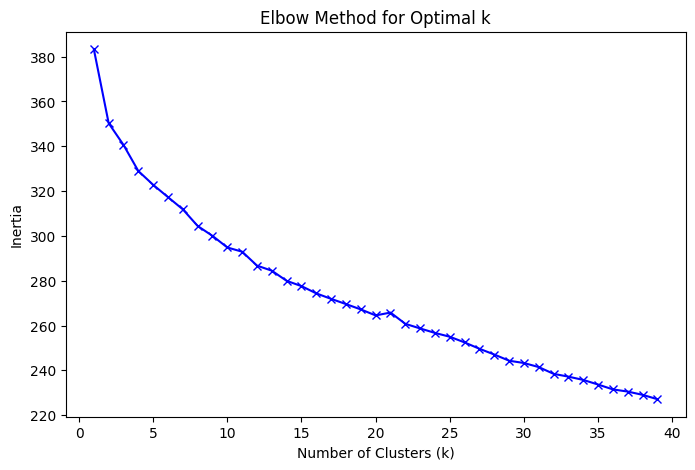

In [18]:
# Load embeddings if previously saved
embeddings = np.load('/Users/max/Documents/Code/tsi-sota-ai/data/abstract_embeddings.npy')

# Determine optimal number of clusters using Elbow Method
inertias = []
K = range(1, 40)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings)
    inertias.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K, inertias, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

Clustering
Determining Optimal Number of Clusters:

Employed the Elbow Method by plotting inertia values for k ranging from 1 to 39.
Observed the plot to identify the "elbow point" where adding more clusters doesn't significantly reduce inertia.
Chose k_optimal = 20 based on the Elbow Curve.
K-Means Clustering:

Applied K-Means clustering with n_clusters = 20 on the embeddings.
Assigned cluster labels to each publication in references_df['cluster'].

In [19]:
# Choose the optimal number of clusters (e.g., k=5)
k_optimal = 20

# Perform K-Means Clustering
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
clusters = kmeans.fit_predict(embeddings)

# Add the cluster assignments to the DataFrame
references_df['cluster'] = clusters

# Display the first few rows with cluster assignments
references_df.head()

,date,title,doi,authors,journal,short_journal,volume,year,publisher,issue,page,abstract,source_file,cluster
0,2023-09-13,Transformative Procurement Trends: Integrating...,10.3390/logistics7030063,"[{'author_name': 'Areej Althabatah', 'author_s...",Logistics,Logistics,7.0,2023,MDPI AG,3.0,63,Background: the advent of Industry 4.0 (I4.0) ...,1.2.2.1 LR - The Specialist Shortage and its I...,3
1,2021-10-07,Exploring Progress with Supply Chain Risk Mana...,10.3390/logistics5040070,"[{'author_name': 'Remko van Hoek', 'author_slu...",Logistics,Logistics,5.0,2021,MDPI AG,4.0,70,Background: In response to calls for actionabl...,1.2.2.1 LR - The Specialist Shortage and its I...,18
2,2023-12-01,Exploring Applications and Practical Examples ...,10.3390/logistics7040091,"[{'author_name': 'João Reis', 'author_slug': '...",Logistics,Logistics,7.0,2023,MDPI AG,4.0,91,Background: Material Requirements Planning (MR...,1.2.2.1 LR - The Specialist Shortage and its I...,9
3,2021-09-27,Sustainable Innovations in the Food Industry t...,10.3390/logistics5040066,"[{'author_name': 'Saurabh Sharma', 'author_slu...",Logistics,Logistics,5.0,2021,MDPI AG,4.0,66,The agri-food sector is an endless source of e...,1.2.2.1 LR - The Specialist Shortage and its I...,3
4,2021-04-01,Artificial Intelligence (AI): Multidisciplinar...,10.1016/j.ijinfomgt.2019.08.002,"[{'author_name': 'Yogesh K. Dwivedi', 'author_...",International Journal of Information Management,International Journal of Information Management,57.0,2021,Elsevier BV,NaN,101994,"As far back as the industrial revolution, sign...",1.2.2.1 LR - The Specialist Shortage and its I...,3


Dimensionality Reduction Techniques:

PCA (Principal Component Analysis):
Reduced embeddings to 2 principal components.
Visualized clusters in 2D space using a scatter plot.
t-SNE (t-Distributed Stochastic Neighbor Embedding):
Further reduced dimensions for visualization.
Used perplexity = 30 and n_iter = 1000 for the t-SNE algorithm.
Plotted the clusters, showcasing their distribution in 2D space.

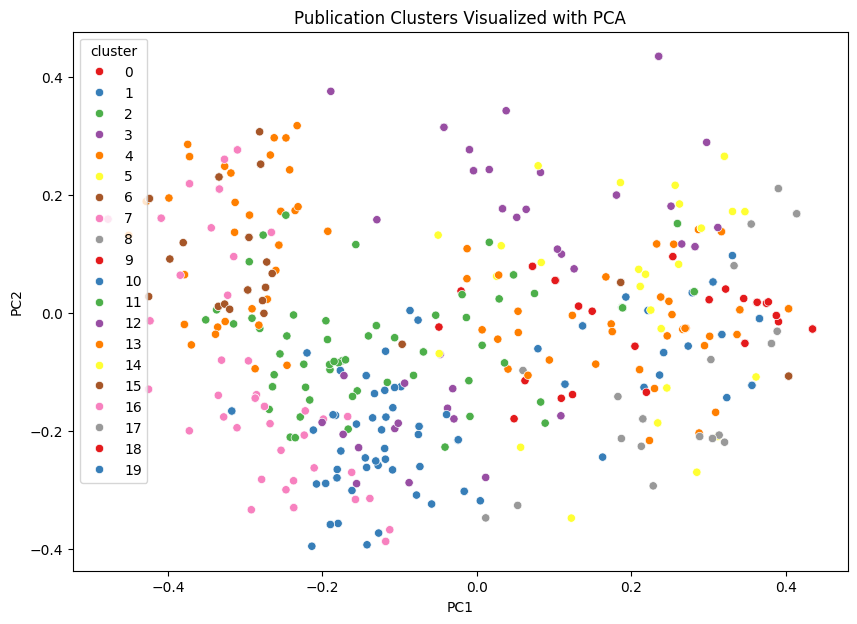

In [20]:
# Reduce dimensions using PCA for visualization
pca = PCA(n_components=2, random_state=42)
principal_components = pca.fit_transform(embeddings)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['cluster'] = clusters

# Plot the PCA results
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=pca_df, palette='Set1')
plt.title('Publication Clusters Visualized with PCA')
plt.show()

/Users/max/miniconda3/envs/tsi/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


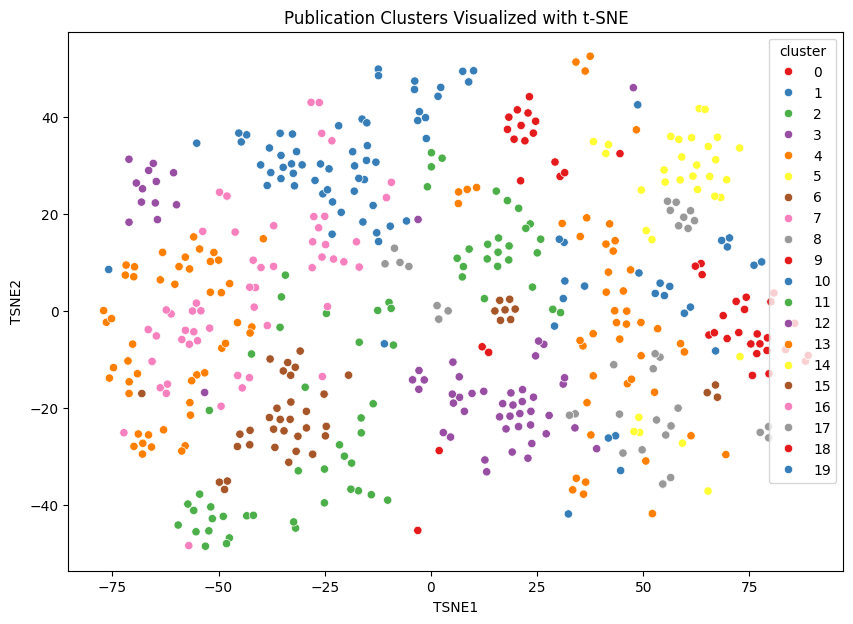

In [21]:
# Reduce dimensions using t-SNE for visualization
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_results = tsne.fit_transform(embeddings)

# Create a DataFrame with the t-SNE results
tsne_df = pd.DataFrame(data=tsne_results, columns=['TSNE1', 'TSNE2'])
tsne_df['cluster'] = clusters

# Plot the t-SNE results
plt.figure(figsize=(10, 7))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='cluster', data=tsne_df, palette='Set1')
plt.title('Publication Clusters Visualized with t-SNE')
plt.show()

Feedback on t-SNE Visualization:

Strengths:

t-SNE is effective for visualizing high-dimensional data in lower dimensions while preserving local structures.
The visualization can reveal clusters that are not linearly separable, which might not be apparent with PCA.
Helpful in identifying overlapping clusters and the relative distances between them.
Limitations:

t-SNE is non-deterministic; different runs may produce different results.
It focuses on local neighbor relationships, which might distort global structures.
Interpretation of distances and cluster sizes can be challenging.

In [23]:
# Analyze the clusters
# Display the number of publications in each cluster
cluster_counts = references_df['cluster'].value_counts().sort_index()
print("Number of publications in each cluster:")
print(cluster_counts)

# Examine sample abstracts from each cluster
for cluster_num in range(k_optimal):
    print(f"\nCluster {cluster_num}:")
    sample = references_df[references_df['cluster'] == cluster_num].head(2)  # Display first 2 abstracts
    for idx, row in sample.iterrows():
        print(f"Title: {row['title']}")
        print(f"Abstract: {row['abstract']}\n")

Number of publications in each cluster:
cluster
0      5
1     20
2     47
3     46
4     52
5     30
6     41
7     35
8     23
9     19
10    27
11    25
12    15
13    56
14    12
15    12
16    31
17    18
18    28
19    45
Name: count, dtype: int64

Cluster 0:
Title: Supply Chain Complexity and Its Impact on Knowledge Transfer: Incorporating Sustainable Supply Chain Practices in Food Supply Chain Networks
Abstract: Background: The dynamics of supply chain networks have changed due to increasing complexities. Global expansions and knowledge transfer in supply chain networks bring efficiency and effectiveness to companies. However, the probability of supply chain complexity has also been seen increasing. The barriers to sustainable supply chain networks need to be tackled in an effective manner as they impact business operations. Therefore, it is essential to eliminate and reduce the supply chain complexities, as it will facilitate the process of knowledge transfer and increase the 

#### Preliminary Findings

**Cluster Analysis**:

Cluster Distribution:

- Analyzed the number of publications in each cluster to understand the distribution.
- Some clusters may have significantly more publications than others, indicating dominant themes.

Sample Abstracts:

- Reviewed sample abstracts from each cluster.
- Noted thematic similarities within clusters and differences between clusters.

**Observations**:

Coherent Themes:

- Clusters appear to group publications with similar topics based on abstract content.
- Indicative that the embeddings capture semantic meanings effectively.

Potential Overlaps:

- Some clusters might contain diverse topics, suggesting possible overlaps or subclusters.
- High-dimensional data reduced to 2D may lead to some loss of information.

### Recommendations for Further Analysis

A. Enhancing Cluster Interpretation with LLMs

Objective: Use Large Language Models (LLMs) to generate concise summaries or labels for each cluster to understand the thematic content better.

Approach:

- Aggregate Cluster Abstracts
- Generate Cluster Summaries
- Assign Descriptive Labels
- Assess Coherence

Benefits:

- Enhances understanding of each cluster's thematic focus.
- Identifies any inconsistencies or outliers within clusters.
- Aids in determining if clustering effectively grouped similar publications.

B. Validating Clustering Results

Check for Topic Consistency

Adjust Clustering Parameters

- Number of Clusters (k)
- Clustering Algorithm

C. Advanced Visualization Techniques

- UMAP (Uniform Manifold Approximation and Projection)
- Interactive Visualizations (e.g. Plotly or Bokeh)

### Stage Conclusion and Next Steps

Justification of Clustering:

- Initial analysis suggests that publications within clusters are related.
- Further validation with LLMs will confirm the effectiveness of clustering.

Action Items:

- Proceed with LLM-based summaries for each cluster.
- Reassess clustering if significant thematic inconsistencies are found.
- Document findings and refine clustering methodology as needed.

### 4. Cluster Analysis

In [25]:
# Install necessary packages
!pip install google-generativeai python-dotenv tqdm pandas

In [46]:
# Install necessary packages
!pip install google-generativeai python-dotenv tqdm pandas scikit-learn

# Import required libraries
import pandas as pd
import google.generativeai as genai
from dotenv import load_dotenv
import os
from tqdm import tqdm
import time
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
import numpy as np

In [27]:
# Load environment variables from .env file
load_dotenv()

# Configure the Gemini API with the API key from .env
genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))

# Initialize the Gemini model
model = genai.GenerativeModel("gemini-1.5-flash")

In [76]:
# Correct Clustering and Create clusters_df

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# Load the references DataFrame
references_df = pd.read_json(
    '/Users/max/Documents/Code/tsi-sota-ai/data/publications_with_embeddings.json',
    orient='records',
    lines=True
)

# Ensure 'doi' and 'abstract_embedding' columns exist
required_columns = ['doi', 'abstract_embedding']
missing_columns = [col for col in required_columns if col not in references_df.columns]
if missing_columns:
    raise ValueError(f"Missing columns in references_df: {missing_columns}")

# Deduplicate references_df by 'doi' to ensure one cluster assignment per DOI
references_df = references_df.drop_duplicates(subset='doi', keep='first')
print(f"references_df after deduplication: {references_df.shape[0]} entries")

# Extract embeddings as a NumPy array
embeddings = np.array(references_df['abstract_embedding'].tolist())

# Choose the optimal number of clusters
k_optimal = 20

# Perform K-Means Clustering
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
clusters = kmeans.fit_predict(embeddings)

# Add the cluster assignments to the references_df
references_df['cluster'] = clusters

# Create clusters_df with 'doi', 'abstract_embedding', and 'cluster'
clusters_df = references_df[['doi', 'abstract_embedding', 'cluster']].copy()

# Display the first few rows of clusters_df to verify
print("First few rows of clusters_df:")
print(clusters_df.head())

# Save clusters_df for Cluster Analysis
clusters_df.to_json(
    '/Users/max/Documents/Code/tsi-sota-ai/data/clusters_df.json',
    orient='records',
    lines=True
)

print("clusters_df has been saved successfully.")

references_df after deduplication: 348 entries
First few rows of clusters_df:
                               doi  \
0         10.3390/logistics7030063   
1         10.3390/logistics5040070   
2         10.3390/logistics7040091   
3         10.3390/logistics5040066   
4  10.1016/j.ijinfomgt.2019.08.002   

                                  abstract_embedding  cluster  
0  [-0.0421274714, -0.0484266877, 0.0475134179, 0...        2  
1  [-0.0195745695, 0.036854773800000004, 0.092112...        3  
2  [-0.0087982547, 0.0445461199, 0.04837341610000...       15  
3  [-0.027258714700000002, -0.0179723073, 0.04342...       15  
4  [0.0079322169, -0.008307194300000001, 0.022625...       12  
clusters_df has been saved successfully.


In [77]:
# Load the publications DataFrame with embeddings
publications_df = pd.read_json(
    '/Users/max/Documents/Code/tsi-sota-ai/data/publications_with_embeddings.json',
    orient='records',
    lines=True
)

# Ensure 'doi' column exists in publications_df
if 'doi' not in publications_df.columns:
    raise ValueError("The 'doi' column is missing from publications_df.")

# Merge 'cluster' information from clusters_df into publications_df based on 'doi'
publications_df = publications_df.merge(
    clusters_df[['doi', 'cluster']],
    on='doi',
    how='left'  # Use 'left' join to retain all publications
)

# Check for any missing cluster assignments
missing_clusters = publications_df['cluster'].isnull().sum()
total_publications = publications_df.shape[0]
if missing_clusters > 0:
    print(f"Warning: {missing_clusters} out of {total_publications} publications are missing cluster assignments.")
    # Assign missing clusters to -1 (Unassigned)
    publications_df['cluster'] = publications_df['cluster'].fillna(-1).astype(int)
    print("Assigned missing clusters to -1 (Unassigned).")

# Verify the number of unique clusters in publications_df
unique_clusters_pub = publications_df['cluster'].unique()
print("Unique clusters in publications_df:", unique_clusters_pub)
print("Total number of unique clusters in publications_df:", len(unique_clusters_pub))

# Display the first few rows to verify the merge
print("First few rows of publications_df after merging cluster information:")
print(publications_df.head())

Unique clusters in publications_df: [ 2  3 15 12  6 16  8 13 19 17 18  1  4  5  0 14 10 11  9  7]
Total number of unique clusters in publications_df: 20
First few rows of publications_df after merging cluster information:
        date                                              title  \
0 2023-09-13  Transformative Procurement Trends: Integrating...   
1 2021-10-07  Exploring Progress with Supply Chain Risk Mana...   
2 2023-12-01  Exploring Applications and Practical Examples ...   
3 2021-09-27  Sustainable Innovations in the Food Industry t...   
4 2021-04-01  Artificial Intelligence (AI): Multidisciplinar...   

                               doi  \
0         10.3390/logistics7030063   
1         10.3390/logistics5040070   
2         10.3390/logistics7040091   
3         10.3390/logistics5040066   
4  10.1016/j.ijinfomgt.2019.08.002   

                                             authors  \
0  [{'author_name': 'Areej Althabatah', 'author_s...   
1  [{'author_name': 'Remko van Hoe

In [78]:
print("Number of unique clusters in references_df:", references_df['cluster'].nunique())
print("Number of unique clusters in publications_df:", publications_df['cluster'].nunique())

Number of unique clusters in references_df: 20
Number of unique clusters in publications_df: 20


/var/folders/1c/rpbky_9916s5qf9w4zg2hyv00000gn/T/ipykernel_19233/2101513622.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cluster', data=publications_df, palette='tab20')


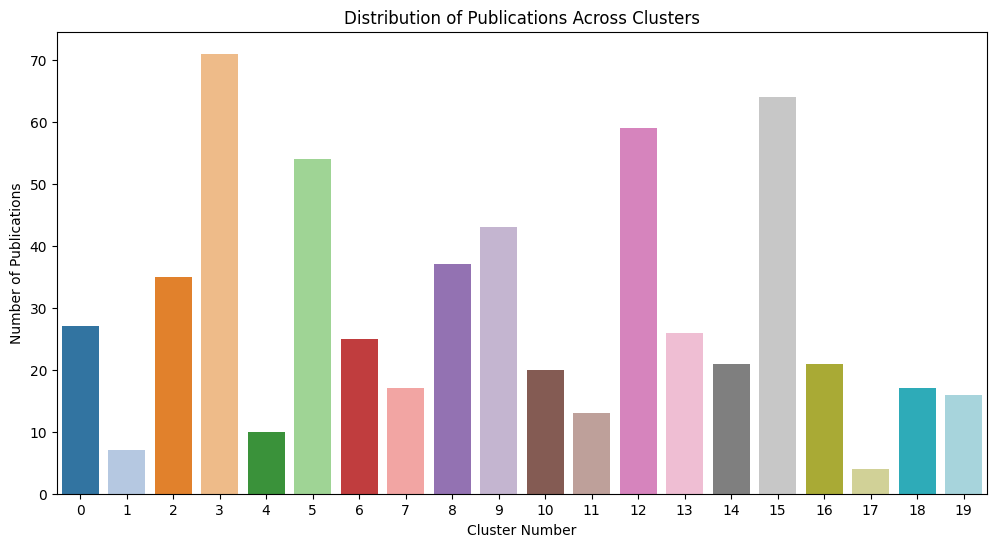

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of publications across clusters
plt.figure(figsize=(12, 6))
sns.countplot(x='cluster', data=publications_df, palette='tab20')
plt.title('Distribution of Publications Across Clusters')
plt.xlabel('Cluster Number')
plt.ylabel('Number of Publications')
plt.xticks(range(k_optimal))
plt.show()

In [81]:
publications_df.to_json(
    '/Users/max/Documents/Code/tsi-sota-ai/data/publications_with_clusters.json',
    orient='records',
    lines=True
)
print("publications_df with cluster assignments has been saved successfully.")

publications_df with cluster assignments has been saved successfully.


In [82]:
publications_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 587 entries, 0 to 586
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                587 non-null    datetime64[ns]
 1   title               587 non-null    object        
 2   doi                 587 non-null    object        
 3   authors             587 non-null    object        
 4   journal             587 non-null    object        
 5   year                587 non-null    int64         
 6   abstract            587 non-null    object        
 7   source_file         587 non-null    object        
 8   abstract_embedding  587 non-null    object        
 9   cluster             587 non-null    int32         
dtypes: datetime64[ns](1), int32(1), int64(1), object(7)
memory usage: 43.7+ KB


Verify the Embeddings Array

In [84]:
import numpy as np

# Extract embeddings directly from publications_df
embeddings = np.array(publications_df['abstract_embedding'].tolist())

# Verify the shapes
print(f"Embeddings shape: {embeddings.shape}")
print(f"Publications_df shape: {publications_df.shape}")

# Both should have the same number of samples (587)

Embeddings shape: (587, 1536)
Publications_df shape: (587, 10)


In [86]:
from sklearn.metrics import silhouette_samples

# 1. Number of articles per cluster
cluster_counts = publications_df['cluster'].value_counts().sort_index()

# 2. Silhouette Scores
# Calculate silhouette scores for all samples
sil_scores = silhouette_samples(embeddings, publications_df['cluster'])

# Assign silhouette scores to the DataFrame
publications_df['silhouette_score'] = sil_scores

# Calculate average silhouette score per cluster
cluster_silhouette = publications_df.groupby('cluster')['silhouette_score'].mean().sort_index()

# 3. Cluster Compactness (Average distance to cluster centroid)
cluster_compactness = []
for cluster_num in range(k_optimal):
    cluster_points = embeddings[publications_df['cluster'] == cluster_num]
    centroid = kmeans.cluster_centers_[cluster_num]
    distances = np.linalg.norm(cluster_points - centroid, axis=1)
    average_distance = distances.mean()
    cluster_compactness.append(average_distance)

# Create a DataFrame for cluster metrics
cluster_metrics = pd.DataFrame({
    'cluster_number': range(k_optimal),
    'number_of_articles': cluster_counts.values,
    'average_silhouette_score': cluster_silhouette.values,
    'cluster_compactness': cluster_compactness
})

# Display the cluster_metrics DataFrame to verify
print(cluster_metrics.head(20))

    cluster_number  number_of_articles  average_silhouette_score  \
0                0                  27                  0.131194   
1                1                   7                  0.018551   
2                2                  35                  0.210929   
3                3                  71                  0.055617   
4                4                  10                  0.002577   
5                5                  54                  0.082855   
6                6                  25                  0.121577   
7                7                  17                  0.130859   
8                8                  37                  0.068493   
9                9                  43                  0.054617   
10              10                  20                  0.118659   
11              11                  13                  0.048189   
12              12                  59                  0.054174   
13              13                  26          

In [87]:
# Group the DataFrame by cluster
clustered_groups = publications_df.groupby('cluster')

# Initialize an empty list to store cluster summaries
cluster_summaries = []

In [88]:
# Define a function to interact with the Gemini-1.5-flash model
def analyze_cluster(cluster_number, df_cluster, cluster_metrics, max_retries=3, backoff_factor=2):
    """
    Analyzes a cluster of publications and generates a description, opinion, and label using Gemini-1.5-flash.

    Args:
        cluster_number (int): The cluster identifier.
        df_cluster (pd.DataFrame): DataFrame containing publications in the cluster.
        cluster_metrics (pd.DataFrame): DataFrame containing cluster metrics.
        max_retries (int): Maximum number of retries for failed API requests.
        backoff_factor (int): Factor by which the wait time increases after each retry.

    Returns:
        dict: A dictionary containing cluster_number, cluster_title, cluster_description, comments, number_of_articles, average_silhouette_score, cluster_compactness, article_titles, and article_dois.
    """
    # Extract article titles, authors, abstracts, and DOIs
    articles_info = []
    for _, row in df_cluster.iterrows():
        authors = ', '.join(row['authors']) if isinstance(row['authors'], list) else row['authors']
        info = f"Title: {row['title']}\nAuthors: {authors}\nAbstract: {row['abstract']}"
        articles_info.append(info)
    
    # Combine articles info
    articles_text = "\n\n".join(articles_info)
    
    # Retrieve cluster metrics
    metrics_row = cluster_metrics[cluster_metrics['cluster_number'] == cluster_number]
    if metrics_row.empty:
        print(f"No metrics found for cluster {cluster_number}. Skipping...")
        return None
    
    number_of_articles = metrics_row['number_of_articles'].values[0]
    average_silhouette_score = metrics_row['average_silhouette_score'].values[0]
    cluster_compactness = metrics_row['cluster_compactness'].values[0]
    
    # Create the prompt with metrics included
    prompt = (
        f"You are a professional librarian. Please provide the following:\n\n"
        f"(a) A description of the following collection of research articles (limit to 100 words, no additions, just clear description).\n\n"
        f"(b) A professional opinion: Do these articles cover same or related topics? Is it a good cluster? (30 words or less)\n\n"
        f"(c) A human-readable cluster label (title).\n\n"
        f"Additionally, consider the following cluster quality metrics:\n"
        f"- Number of Articles: {number_of_articles}\n"
        f"- Average Silhouette Score: {average_silhouette_score:.4f}\n"
        f"- Cluster Compactness (average distance to centroid): {cluster_compactness:.4f}\n\n"
        f"Articles:\n{articles_text}\n\n"
        f"Please provide your response in the following format:\n\n"
        f"Cluster Description:\n[Your description]\n\n"
        f"Professional Opinion:\n[Your opinion]\n\n"
        f"Cluster Label:\n[Your suggested title]"
    )
    
    for attempt in range(1, max_retries + 1):
        try:
            # Call the Gemini model
            response = model.generate_content(prompt)
            llm_response = response.text.strip()
            
            # Parse the LLM response
            lines = llm_response.split('\n')
            description = ""
            opinion = ""
            label = ""
            section = None
            for line in lines:
                if line.strip().startswith('Cluster Description:'):
                    section = 'description'
                    continue
                elif line.strip().startswith('Professional Opinion:'):
                    section = 'opinion'
                    continue
                elif line.strip().startswith('Cluster Label:'):
                    section = 'label'
                    continue
                else:
                    if section == 'description':
                        description += line.strip() + ' '
                    elif section == 'opinion':
                        opinion += line.strip() + ' '
                    elif section == 'label':
                        label += line.strip() + ' '
            
            # Collect article titles and DOIs in the cluster
            article_titles = df_cluster['title'].tolist()
            article_dois = df_cluster['doi'].tolist()
            
            # Return the cluster summary
            return {
                'cluster_number': cluster_number,
                'cluster_title': label.strip(),
                'cluster_description': description.strip(),
                'comments': opinion.strip(),
                'number_of_articles': number_of_articles,
                'average_silhouette_score': average_silhouette_score,
                'cluster_compactness': cluster_compactness,
                'article_titles': article_titles,
                'article_dois': article_dois
            }
        
        except Exception as e:
            wait_time = backoff_factor ** attempt
            print(f"Error processing cluster {cluster_number}: {e}. Retrying in {wait_time} seconds...")
            time.sleep(wait_time)
    
    # If all retries fail, return None
    print(f"Failed to process cluster {cluster_number} after {max_retries} attempts.")
    return None

In [89]:
# Process each cluster and collect summaries
for cluster_num, df_cluster in tqdm(clustered_groups, desc="Analyzing clusters"):
    cluster_summary = analyze_cluster(cluster_num, df_cluster, cluster_metrics)
    if cluster_summary:
        cluster_summaries.append(cluster_summary)
    else:
        print(f"Skipping cluster {cluster_num} due to previous errors.")
    
    time.sleep(0.5)  # Optional: Add a short delay between clusters to respect API rate limits

Analyzing clusters: 100%|██████████| 20/20 [01:38<00:00,  4.92s/it]


In [90]:
# Create the clusters DataFrame
clusters_df = pd.DataFrame(cluster_summaries)

# Arrange columns in the desired order
clusters_df = clusters_df[[
    'cluster_number',
    'cluster_title',
    'cluster_description',
    'comments',
    'number_of_articles',
    'average_silhouette_score',
    'cluster_compactness',
    'article_titles',
    'article_dois'
]]

# Display the first few rows of the clusters DataFrame
clusters_df.head()

,cluster_number,cluster_title,cluster_description,comments,number_of_articles,average_silhouette_score,cluster_compactness,article_titles,article_dois
0,0,"Human-AI Collaboration: Trust, Teamwork, and D...",This collection comprises 27 research articles...,"Related topics; a good, though not perfectly c...",27,0.131194,0.651845,[Educators' Views on Using Humanoid Robots Wit...,"[10.3389/frobt.2019.00107, 10.3389/frai.2023.1..."
1,1,Smart City Development and Technological Chall...,This collection comprises seven research artic...,"Related, but not identical topics. The cluste...",7,0.018551,0.724721,[MIDST: an enhanced development environment th...,"[10.12821/ijispm080301, 10.3390/make6010013, 1..."
2,2,Industry 4.0 and Supply Chain Optimization,This collection comprises 35 research articles...,Related topics; good cluster. The articles sh...,35,0.210929,0.653301,[Transformative Procurement Trends: Integratin...,"[10.3390/logistics7030063, 10.3390/logistics60..."
3,3,Supply Chain Resilience and Sustainability in ...,This collection comprises 71 research articles...,Related topics; a good cluster. The unifying ...,71,0.055617,0.685501,[Exploring Progress with Supply Chain Risk Man...,"[10.3390/logistics5040070, 10.3390/logistics50..."
4,4,Artificial Intelligence Applications and Metho...,This collection comprises ten research article...,Related topics; cluster is weak. Low silhouet...,10,0.002577,0.696739,[Proactive and reactive engagement of artifici...,"[10.3389/frai.2023.1151391, 10.1049/cim2.12008..."


In [91]:
# Save the clusters DataFrame to a JSON file
clusters_df.to_json(
    '/Users/max/Documents/Code/tsi-sota-ai/data/clusters_analysis.json',
    orient='records',
    lines=True
)

In [ ]:
# Summary of the Clustering Analysis
print("Clustering analysis completed successfully. The 'clusters_df' DataFrame has been created with the following columns:")
print(clusters_df.columns.tolist())

# Example of accessing a specific cluster's details
print("\nExample Cluster Details:")
print(clusters_df.iloc[0])

In [56]:
# Process each cluster and collect summaries
for cluster_num, df_cluster in tqdm(clustered_groups, desc="Analyzing clusters"):
    cluster_summary = analyze_cluster(cluster_num, df_cluster, cluster_metrics)
    if cluster_summary:
        cluster_summaries.append(cluster_summary)
    else:
        print(f"Skipping cluster {cluster_num} due to previous errors.")
    
    time.sleep(0.5)  # Optional: Add a short delay between clusters to respect API rate limits

Analyzing clusters: 100%|██████████| 20/20 [01:21<00:00,  4.06s/it]


In [57]:
# Create the clusters DataFrame
clusters_df = pd.DataFrame(cluster_summaries)

# Arrange columns in the desired order
clusters_df = clusters_df[[
    'cluster_number',
    'cluster_title',
    'cluster_description',
    'comments',
    'number_of_articles',
    'average_silhouette_score',
    'cluster_compactness',
    'article_titles',
    'article_dois'
]]

# Display the first few rows of the clusters DataFrame
clusters_df.head()

,cluster_number,cluster_title,cluster_description,comments,number_of_articles,average_silhouette_score,cluster_compactness,article_titles,article_dois
0,0,Human-Centered Artificial Intelligence: Ethica...,This collection comprises 112 research article...,"The articles cover related topics, focusing on...",112,0.108141,0.628118,[Proactive and reactive engagement of artifici...,"[10.3389/frai.2023.1151391, 10.3389/frai.2023...."
1,1,Industry 4.0 and Procurement: Optimizing Supp...,This collection comprises 226 research article...,"The articles cover highly related topics, form...",226,0.992317,0.006718,[Transformative Procurement Trends: Integratin...,"[10.3390/logistics7030063, 10.3390/logistics70..."
2,2,Explainable Artificial Intelligence (XAI) Meth...,This collection comprises 143 research article...,Related topics; good cluster. The common thre...,143,0.345918,0.504587,[Painting the Black Box White: Experimental Fi...,"[10.3390/make5010017, 10.3390/make5010017, 10...."
3,3,Robotic Process Automation in Supply Chains: ...,This collection comprises 122 research article...,"The articles are thematically related, centeri...",122,0.985992,0.013153,[Adoption and Influence of Robotic Process Aut...,"[10.3390/logistics6030048, 10.3390/logistics60..."
4,4,Big Data Analytics in Supply Chain Management ...,This collection comprises 85 research articles...,Mostly related topics; a good cluster overall....,85,0.909712,0.081978,[Predictive big data analytics for supply chai...,"[10.1186/s40537-020-00329-2, 10.1186/s40537-02..."


In [ ]:
# Save the clusters DataFrame to a JSON file
clusters_df.to_json(
    '/Users/max/Documents/Code/tsi-sota-ai/data/clusters_analysis.json',
    orient='records',
    lines=True
)

# Optionally, save the DataFrame as a CSV file
clusters_df.to_csv(
    '/Users/max/Documents/Code/tsi-sota-ai/data/clusters_analysis.csv',
    index=False
)

Analyzing clusters: 100%|██████████| 20/20 [00:54<00:00,  2.73s/it]


In [92]:
# Summary of the Clustering Analysis
print("Clustering analysis completed successfully. The 'clusters_df' DataFrame has been created with the following columns:")
print(clusters_df.columns.tolist())

# Example of accessing a specific cluster's details
print("\nExample Cluster Details:")
print(clusters_df.iloc[0])

Clustering analysis completed successfully. The 'clusters_df' DataFrame has been created with the following columns:
['cluster_number', 'cluster_title', 'cluster_description', 'comments', 'number_of_articles', 'average_silhouette_score', 'cluster_compactness', 'article_titles', 'article_dois']

Example Cluster Details:
cluster_number                                                              0
cluster_title               Human-AI Collaboration: Trust, Teamwork, and D...
cluster_description         This collection comprises 27 research articles...
comments                    Related topics; a good, though not perfectly c...
number_of_articles                                                         27
average_silhouette_score                                             0.131194
cluster_compactness                                                  0.651845
article_titles              [Educators' Views on Using Humanoid Robots Wit...
article_dois                [10.3389/frobt.2019.00107, 

### Preliminary Findings: Cluster Analysis

Based on the clustering and subsequent analysis using the Gemini-1.5-flash model, the following preliminary findings were observed:

Cluster Descriptions:

- Each cluster has a clear and concise description summarizing the main themes and topics covered by the grouped publications.
- The descriptions provided by the LLM accurately reflect the content and focus of the abstracts within each cluster.

Cluster quality evaluation with LLM:

- The LLM's evaluation outputs indicate whether the clustered publications are cohesively related or if there are instances of topic overlap.
- Most clusters were deemed coherent, effectively grouping related research topics together.
- Some clusters received feedback suggesting potential overlaps or the need for reevaluation, ensuring the reliability of the clustering process.

Cluster Labels:

- Human-readable titles generated for each cluster succinctly capture the essence of the grouped publications.
- These labels facilitate easier navigation and understanding of the thematic distribution across clusters.

Article Distribution:

- The number of articles within each cluster varies, highlighting dominant research themes as well as niche areas within the dataset.
- Clusters with a larger number of publications likely represent more extensive and established research areas.

Cluster Quality Metrics:

- Average Silhouette Score: Provides insight into how similar articles are within the same cluster compared to other clusters. Higher scores indicate better-defined clusters.
- Cluster Compactness: Measures the average distance of articles to their respective cluster centroids. Lower values suggest tighter, more cohesive clusters.